# Gaussian RBF estimate based on "attachment" points

## Idea

Let $\{x_1.\ldots,x_s\}\subset X$ represent a series of "sites" in a compact subset $X\subset \mathbb{R}^d$. For each site $x_i$ there is a certain amount of "mass" $y_i$ or demand that is measured at the site.

The idea is that this mass comes from a suitable density function $f:X\to\mathbb{R}$ such that:

$$\int_{V_i} f(x) dx = y_i, \quad i=1,\ldots,s.$$

Here $V_i$ is the *Voronoi cell* associated to site $x_i$, i.e.:

$$V_j = \left\{x\in X: ||x-x_i||\leqslant ||x - x_j||, j=1,\ldots,s\right\}$$

## Radial basis functions approach

We want to estimate $f$ from the "attachment" observations $\{y_i\}$ at sites $\{x_i\}$. To do so we choose a parametric family for $f$ based on Gaussian radial basis functions, in order to obtain a low-dimensional continuous density that suits our needs.

Let $g(x;\theta):X\subset R^d \to \mathbb{R}$ be given by:

$$g(x;\theta) = \sum_{j=1}^n w_j e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$$

a linear combination of $d$ dimensional (isotropic) Gaussian kernels with centers $\mu_j$, variances $\sigma^2_j$ and weights $w_j$. We combine all these parameters in $\theta = (\mu,\sigma^2, w)$. We want to keep the number of centers $n$ as low as possible to keep the dimensionality down.

> *Example*: The number of parameters to estimate in $\theta$ is d+2 for each kernel, so the total number of parameters is (d+2)n. For $d=2$, this is $4n$ and we want to keep that below $s$, the number of attachement observations.

## Regression

The idea is to estimate $\theta$ by minimizing the following least squares loss function $L$:

$$\min_{\theta} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2.$$

We propose to do so by following a gradient descent procedure. In order to do so we need:

* To compute the gradient of $L(\theta)$ for each parameter.
* In particular, find a way to evaluate $\int_{V_j} g(x;\theta) dx$ on each Voronoi cell $V_i$.

## Computing the gradient

Let us begin by computing the gradient with respect to $\theta_k$, one of the parameters:

$$\begin{align}
\frac{\partial L}{\partial \theta_k} &= \sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right] \frac{\partial}{\partial \theta_k} \left[\int_{V_i} g(x;\theta) dx\right] \\
&= \sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right] \int_{V_i}  \frac{\partial}{\partial \theta_k} g(x;\theta) dx,
\end{align}$$

where in the last term we used that the Voronoi cells are fixed and do not depend on $\theta$. Therefore we need to compute the partial derivatives of the function $g$ with respect to the paramteres. If $\theta_k$ appears only in kernel $j$, then what we need is the derivative of each kernel funciton with respect of each of its parameters.

## Partial derivatives for the gradient

If $g(x;\theta) = \sum_{j=1}^n w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$ we can compute:

$$\begin{align*}
\frac{\partial g}{\partial w_j} &= e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}. \\
\frac{\partial g}{\partial \sigma_j^2} &= w_j e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}\left[ \frac{(x-\mu_j)^T(x-\mu_j)}{2((\sigma_j^2)^2)} \right].
\end{align*}
$$
Finally, we differentiate with respect to each coordiante of the center $\mu_j$:
$$
\begin{equation*}
\frac{\partial g}{\partial \mu_{j,l} }= \frac{w_j}{\sigma_j^2} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)} (x_l-\mu_{j,l}), \quad l=1,2
\end{equation*}$$

## Computing the integrals

Note that for the gradient we need to plug in the above derivatives and compute integrals of the form:

$$\int_{V_i} \frac{\partial}{\partial \theta_k} g(x;\theta) dx$$

which in all the above cases translate to the integral on the $i$-th Voronoi cell of some density (or moment) related to the original RBF. For instance for the weights:

$$\int_{V_i} \frac{\partial}{\partial w_j} g(x;\theta) dx = \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}dx,$$

which is the contribution of the $j$ kernel (with weight $1$) to the mass at $i$. Since computing these integrals is obviously hard due to the shape of the Voronoi cells, we follow a Monte Carlo approach by sampling a suitably large number of points using the Gaussin kernel, and estimate the integrals by averaging over the points. This in turn can be done efficiently since the same sampling can be used to compute:

* The three integrals needed for the partial derivatives in the gradient.
* The weights that shall be used for each site $\left[\int_{V_i} g(x;\theta) dx  - y_i \right]$ in the gradient procedure.

## Choosing the initial centers, variances and weights.

A good starting point is needed for the gradient procedure. In order to do so, we fix first the number of kernels $n$ as an hyperparameter, and choose it to be much lower than the number of sites. It seems a good idea to choose a kernel center for each cluster of measurement sites. Therefore, we will make a $k-means$ cluster approach to clusterize the sites (i.e. choose a center $\mu_j$ related to the site geometry). Then we can use the variance of the cluster to have an idea of an adequate $\sigma^2$ to cover all the cluster with one kernel. This assumes that similar sites have similar observations $y_j$, i.e. that the density smoothly varies over the space $X$.

If the centers and variances of the kernels are given, an initial choice for the weights can be computed by minimizing the loss only over them:

$$\min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2,$$

Again, we can compute an estimate of $\int_{V_i} g(x;\theta) dx$ by sampling with the Gaussian distribution. In this case the problem of choosing the initial weights reduces to a finite-dimensional least squares problem as we show below.

Calling $g_j(x)$ the $j$ kernel (without $w_j$) with fixed parameters $\mu_j, \sigma_j^2$, Write the above loss function as:
$$\frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} \sum_{j=1}^n w_j g_j(x) dx  - y_i \right]^2 = \frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^n \left(\int_{V_i} g_j(x) dx\right)w_j  - y_i \right]^2 $$

Defining:
$$A=(a_{ij}) \text{ with } a_{ij} = \int_{V_i} g_j(x) dx,$$

Then the loss function is just:
$$\frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^n a_{ij} w_j  - y_i \right]^2  = \frac{1}{2} ||Aw - y||^2,$$

i.e. a classical least squares problem.

## Complete algorithm

Given a set of sites $x_i$ and mass concentrations $y_i$, $i=1,\ldots,s$, we want to find a suitable RBF function $g(x;\theta)$ such that approximates the observed attachements. To do so we choose a number of kernels $n$ and do:

> **Initialization:** 
> 1. Find $n$ centroids for the sites $x_i$. These will be the starting $\mu_j$.
> 2. Compute the covariance matrix of each cluster. Use $\sigma^2_j$ as the trace of the covariance matrix (dispersion measure of the cluster).
> 3. Solve the finite-dimensional least squares problem to find the remaining initial weights, integrating the RBF kernels via Monte Carlo.
>
> **Gradient step:**
>
> 1. Sample points for Monte Carlo integration in the region.
> 2. Compute an estimate of the gradient of the loss funciton in the centers $\mu_j$ and variances $\sigma_j^2$. This can be done by computing the integrals defining the derivatives via Monte Carlo using the sample points above.
> 3. Update $\theta \Leftarrow \theta - \nu \nabla L$ where $\nu$ is a learning rate or step, adjusting the values of $\mu_j$ and $\sigma_j^2$.
> 4. Update $w_j$ by solving again the ordinary least squares problem and iterate.



In [160]:
using Plots, Distributions, ColorSchemes, Statistics, ProgressMeter

In [123]:
function rbf(x;weights=[1.0],centers=[[0.0,0.0]],sigma2=[1.0])
    
    @assert length(weights)==length(centers)==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x)

    
    kernels = [exp(-sum((x-centers[j]).^2)/(2*sigma2[j])) for j=1:n]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

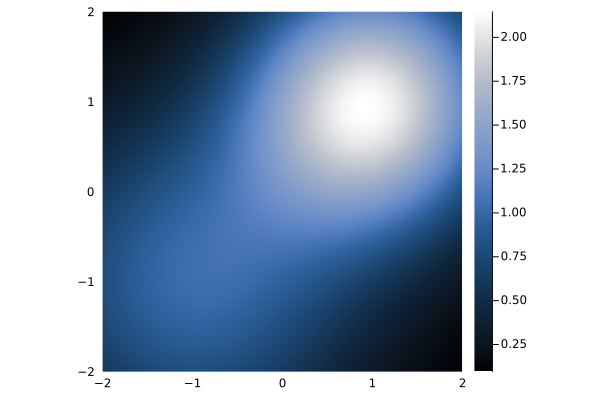

In [124]:
mu = [[-1,-1], [1,1]]
sigma2 = [2,1]
w = [1,2]

x1=(-2:.01:2)
x2=(-2:.01:2)

x=[[a,b] for b in x2, a in x1] ##el orden de b y a importa no entendí por qué.

z = rbf.(x, weights=w,centers=mu,sigma2=sigma2)

heatmap(x1,x2,z, aspect_ratio=:equal, c=:oslo, axis=:off, lims=(-2,2))

In [125]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=1.0)
    
    v=Vector{Vector{Float64}}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = [u1,u2]
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

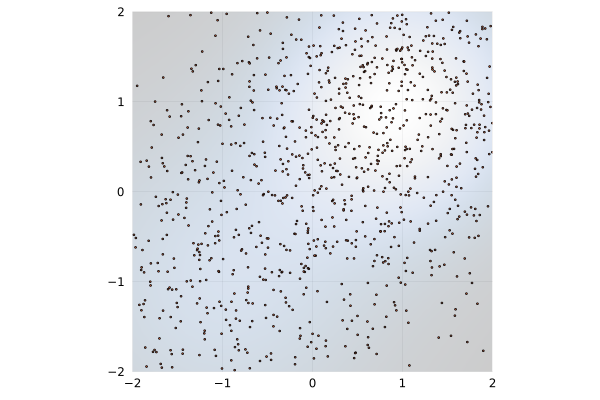

In [126]:
points = sample_rbf(1000, x->rbf(x;weights=w,centers=mu,sigma2=sigma2) ,(-2,2), (-2,2), 2.5)

heatmap(x1,x2,z, aspect_ratio=:equal, c=:oslo, axis=:off, lims=(-2,2),colorbar=:none, alpha=0.2)
scatter!([p[1] for p in points],[p[2] for p in points], aspect_ratio=:equal, axis=:off, lims=(-2,2), label=:none, ms=1)

In [127]:
function integrate2(h,grid,dx,dy)
    return sum(h.(grid)*dx*dy)
end

integrate2(x->rbf(x,weights=w,centers=mu,sigma2=sigma2),x,.01,.01)

15.85890199327471

In [128]:
function distance(x,y)
    sqrt(sum((x-y).^2))
end

distance (generic function with 1 method)

In [129]:
function average_over_voronoi(f::Function, u::Vector{Vector{Float64}}, y::Vector{Vector{Float64}})

    N=length(u)
    F = zeros(length(y))
    for k=1:N
        _,idx = findmin(distance.(y,Ref(u[k])))
        F[idx]+=f(u[k])
    end

    integrals = 1/N * F
    
end



average_over_voronoi (generic function with 1 method)

In [130]:
xlims=[-2.0,2.0]
ylims=[-2.0,2.0]
area = (xlims[2]-xlims[1])*(ylims[2]-ylims[1])

Nsites = 20
sites = [ [rand(Uniform(xlims[1],xlims[2])), rand(Uniform(ylims[1],ylims[2]))]   for i=1:Nsites]


N=10000

u1=rand(Uniform(xlims[1],xlims[2]),N)
u2=rand(Uniform(ylims[1],ylims[2]),N)

u = [[u1[i],u2[i]] for i=1:N]

y= average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;

In [131]:
function update_w(mu,sigma2,y,sites,u,area)

    Nsites = length(sites)
    A=zeros(Nsites,length(mu))

    for j=1:length(mu)
        A[:,j] = average_over_voronoi(x->rbf(x;weights=[1.0],centers=[mu[j]],sigma2=[sigma2[j]]), u, sites)*area
    end
    return A\y
end

update_w (generic function with 1 method)

In [132]:
function compute_gradient(w,mu,sigma2, y, sites, u, area)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = yact - y

    dw1 = residuals'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dw2 = residuals'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu11 = residuals'*average_over_voronoi(x->(x[1]-mu[1][1])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu12 = residuals'*average_over_voronoi(x->(x[2]-mu[1][2])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu21 = residuals'*average_over_voronoi(x->(x[1]-mu[2][1])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu22 = residuals'*average_over_voronoi(x->(x[2]-mu[2][2])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;

    dsigma1 = residuals'*average_over_voronoi(x->sum((x-mu[1]).^2)/(2*sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dsigma2 = residuals'*average_over_voronoi(x->sum((x-mu[2]).^2)/(2*sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[1]],sigma2=sigma2[2]), u, sites)*area;

    return [dw1,dw2,dmu11,dmu12,dmu21,dmu22,dsigma1,dsigma2]
end


compute_gradient (generic function with 1 method)

In [133]:
function compute_loss(w,mu,sigma2, y, sites, u, area)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = yact - y
    return sum(residuals.^2)

end

compute_loss (generic function with 1 method)

In [134]:
mu0 = [[0.8,0.8],[-0.8,-0.8]]
sigma20 = [1.0,1.0]

w0=[1.0,1.0]
nu=0.05

west=w0
muest=mu0
sigma2est=sigma20

N=1000

niter=100
L=zeros(niter)

for iter=1:niter

    u1=rand(Uniform(xlims[1],xlims[2]),N)
    u2=rand(Uniform(ylims[1],ylims[2]),N)
        
    u = [[u1[i],u2[i]] for i=1:N]

    grad = compute_gradient(west,muest,sigma2est,y,sites,u,area)
    west = west - nu*grad[1:2]
    muest = [muest[1]-nu*grad[3:4],muest[2]-nu*grad[5:6]]
    sigma2est = sigma2est - nu*grad[7:8]
#    west = update_w(muest,sigma2est,y,sites,u,area)
    L[iter] = compute_loss(west,muest,sigma2est,y,sites,u,area)
end


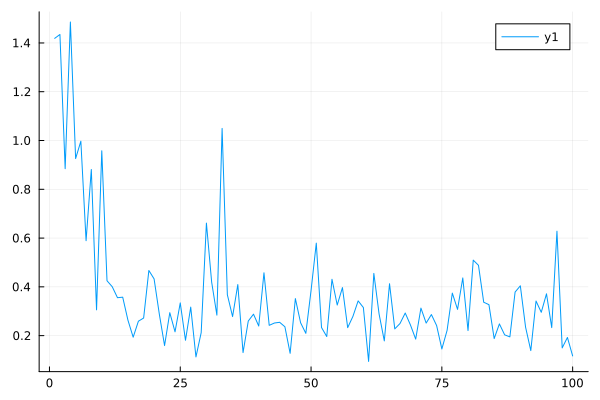

In [135]:
plot(L)

In [136]:
west

2-element Vector{Float64}:
 1.7892277219141357
 1.0123358448435378

In [137]:
function logfactorial(n)

    if n==0
        return 0
    else
        return sum(log.(1:n))
    end
end

logfactorial (generic function with 1 method)

In [138]:
function compute_loglik(w,mu,sigma2, nu, n, y, sites, u, area)

    lambda_act = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;

    loglik=0
    for i=1:length(lambda_act)
        if n[i]>0
            loglik = loglik +  sum( -lambda_act[i] + n[i].*log.(lambda_act[i]) + n[i]*log(nu) + (n[i] .- 1).*log.(y[i]) -nu*y[i] - logfactorial.(n[i])  - logfactorial.(n[i] .-1))
        end
    end
    
    return loglik

end

compute_loglik (generic function with 1 method)

In [207]:
function compute_gradient_loglik(w,mu,sigma2, nact, sites, u, area)

    lambda_act = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    factor = (nact ./lambda_act .- 1)

    println(w)
    
    dw1 = factor'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dw2 = factor'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu11 = factor'*average_over_voronoi(x->(x[1]-mu[1][1])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu12 = factor'*average_over_voronoi(x->(x[2]-mu[1][2])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu21 = factor'*average_over_voronoi(x->(x[1]-mu[2][1])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu22 = factor'*average_over_voronoi(x->(x[2]-mu[2][2])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;

    dsigma1 = factor'*average_over_voronoi(x->sum((x-mu[1]).^2)/(2*sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dsigma2 = factor'*average_over_voronoi(x->sum((x-mu[2]).^2)/(2*sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[1]],sigma2=sigma2[2]), u, sites)*area;

    return [dw1,dw2,dmu11,dmu12,dmu21,dmu22,dsigma1,dsigma2]
end


compute_gradient_loglik (generic function with 2 methods)

In [209]:
mu0 = [[0.8,0.8],[-0.8,-0.8]]
sigma20 = [1.0,1.0]

w=[100.0,200.0]
w0=[80.0,120.0]
nu0=0.2

N=10000
u1=rand(Uniform(xlims[1],xlims[2]),N)
u2=rand(Uniform(ylims[1],ylims[2]),N)
u = [[u1[i],u2[i]] for i=1:N]

y= 4*average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;

west=w0
muest=mu0
sigma2est=sigma20
nuest = nu0

alpha=0.05
N=1000

niter=100
niter2=10
L=zeros(niter)
lambda_act=zeros(Nsites)
nact=zeros(Nsites)

@showprogress for iter=1:niter
    u1=rand(Uniform(xlims[1],xlims[2]),N)
    u2=rand(Uniform(ylims[1],ylims[2]),N)
        
    u = [[u1[i],u2[i]] for i=1:N]

    lambda_act = average_over_voronoi(x->rbf(x,weights=west,centers=muest,sigma2=sigma2est), u, sites)*area;

    nact = convert.(Int64,floor.(sqrt.(lambda_act.*nuest.*y)))
    
    nuest = sum(nact)/sum(y)
    
    for iter2=1:niter2
        grad = compute_gradient_loglik(west,muest,sigma2est, nact,sites,u,area)

        west = west + alpha*grad[1:2]
        muest = [muest[1]+alpha*grad[3:4],muest[2]+alpha*grad[5:6]]
        sigma2est = sigma2est + alpha*grad[7:8]
        
    end

    L[iter] = compute_loglik(west,muest,sigma2est,nuest,nact, y,sites,u,area)
end


[80.0, 120.0]
[80.06886818666419, 119.9995124408373]
[79.87108836092081, 119.59977362171644]
[79.86702049332442, 119.30626319296115]
[79.86702049332442, 119.02020636923837]
[79.86702049332442, 118.7373554740702]
[79.86702049332442, 118.45783603022018]
[79.86702049332442, 118.18177831777938]
[79.86702049332442, 117.90931715412937]
[79.86702049332442, 117.64059160517418]
[79.86702049332442, 117.37574462140246]
[79.86702049332442, 117.21260816490609]
[79.86702049332442, 117.05266233788818]
[79.86702049332442, 116.8959648288949]


Progress:   2%|▉                                        |  ETA: 0:00:19

[79.86702049332442, 116.74257094760563]
[79.86702049332442, 116.59253326559083]
[79.86702049332442, 116.44590125360929]
[79.86702049332442, 116.30272091884663]
[79.86702049332442, 116.16303444579127]
[79.86702049332442, 116.02687984469868]
[79.86702049332442, 115.89429061179912]
[79.86702049332442, 115.80763431332802]
[79.86702049332442, 115.72362988167117]
[79.86702049332442, 115.64226497202512]
[79.86702049332442, 115.56352403253767]
[79.86702049332442, 115.48738832765571]
[79.86702049332442, 115.41383597903732]
[79.86702049332442, 115.34284202384467]


Progress:   3%|█▎                                       |  ETA: 0:00:18

[79.86702049332442, 115.27437849003498]
[79.86702049332442, 115.2084144880708]
[79.86702049332442, 115.14491631828221]
[79.86702049332442, 115.09306579654924]
[79.86702049332442, 115.0434693456726]
[79.86702049332442, 114.99608296967824]
[79.86702049332442, 114.950860839183]


Progress:   4%|█▋                                       |  ETA: 0:00:17

[79.86702049332442, 114.9077554632494]
[79.86702049332442, 114.86671786572062]
[79.86702049332442, 114.82769776452051]
[79.86702049332442, 114.79064375242095]
[79.86702049332442, 114.75550347781737]
[79.86702049332442, 114.72222382411144]
[79.86702049332442, 114.68463667341848]
[79.86702049332442, 114.6488235191027]
[79.86702049332442, 114.61473316142452]
[79.86702049332442, 114.58231410965321]
[79.86702049332442, 114.55151473209902]
[79.86702049332442, 114.52228340015616]
[79.86702049332442, 114.4945686256302]
[79.86702049332442, 114.46831919073546]


Progress:   5%|██                                       |  ETA: 0:00:16

[79.86702049332442, 114.44348427025993]
[79.86702049332442, 114.42001354550631]
[79.86702049332442, 114.393374758193]
[79.86702049332442, 114.36821084802455]
[79.86702049332442, 114.3444670397354]
[79.86702049332442, 114.32208928043372]
[79.86702049332442, 114.30102434952978]


Progress:   6%|██▌                                      |  ETA: 0:00:16

[79.86702049332442, 114.28121995809397]
[79.86702049332442, 114.26262483768184]
[79.86702049332442, 114.24518881876678]
[79.86702049332442, 114.2288628990114]
[79.86702049332442, 114.21359930168805]
[79.86702049332442, 114.18590423895365]
[79.86702049332442, 114.15956350958592]
[79.86702049332442, 114.13452311202461]
[79.86702049332442, 114.11073012889716]
[79.86702049332442, 114.08813280937667]
[79.86702049332442, 114.06668064049052]
[79.86702049332442, 114.04632440773973]
[79.86702049332442, 114.02701624546376]
[79.86702049332442, 114.00870967744574]


Progress:   7%|██▉                                      |  ETA: 0:00:15

[79.86702049332442, 113.9913596483019]
[79.86702049332442, 113.97170173822919]
[79.86702049332442, 113.95352924945564]
[79.86702049332442, 113.93677244756228]
[79.86702049332442, 113.92136342608455]
[79.86702049332442, 113.90723621170582]
[79.86702049332442, 113.89432685031723]


Progress:   8%|███▎                                     |  ETA: 0:00:15

[79.86702049332442, 113.88257347492707]
[79.86702049332442, 113.8719163565181]
[79.86702049332442, 113.86229793903664]
[79.86702049332442, 113.85366285975323]
[79.86702049332442, 113.83880626204572]
[79.86702049332442, 113.82560459697572]
[79.86702049332442, 113.81396972053079]
[79.86702049332442, 113.80381626369183]
[79.86702049332442, 113.79506176747037]
[79.86702049332442, 113.78762678654948]
[79.86702049332442, 113.78143496361237]
[79.86702049332442, 113.77641307662113]
[79.86702049332442, 113.77249106141979]


Progress:   9%|███▊                                     |  ETA: 0:00:15

[79.86702049332442, 113.76960201208968]
[79.86702049332442, 113.74928123825184]
[79.86702049332442, 113.73046669297996]
[79.86702049332442, 113.71307459509384]
[79.86702049332442, 113.69702426766912]
[79.86702049332442, 113.68223821460792]
[79.86702049332442, 113.66864216853087]


Progress:  10%|████▏                                    |  ETA: 0:00:15

[79.86702049332442, 113.65616511257586]
[79.86702049332442, 113.64473927874265]
[79.86702049332442, 113.63430012541903]
[79.86702049332442, 113.62478629667335]
[79.86702049332442, 113.60461115128395]
[79.86702049332442, 113.58610235742434]
[79.86702049332442, 113.56915895313776]


Progress:  11%|████▌                                    |  ETA: 0:00:14

[79.86702049332442, 113.55368405658466]
[79.86702049332442, 113.53958496675892]
[79.86702049332442, 113.52677322141977]
[79.86702049332442, 113.51516461646591]
[79.86702049332442, 113.50467919105705]
[79.86702049332442, 113.49524118276128]
[79.86702049332442, 113.48677895689286]
[79.86702049332442, 113.4623052170025]
[79.86702049332442, 113.43999133392641]
[79.86702049332442, 113.41969929459185]
[79.86702049332442, 113.40129639179267]
[79.86702049332442, 113.38465551891578]
[79.86702049332442, 113.3696553793616]
[79.86702049332442, 113.35618061769533]


Progress:  12%|████▉                                    |  ETA: 0:00:14

[79.86702049332442, 113.34412188022375]
[79.86702049332442, 113.3333758130409]
[79.86702049332442, 113.32384500566374]
[79.86702049332442, 113.3008842125684]
[79.86702049332442, 113.27974681482843]
[79.86702049332442, 113.26030262286159]
[79.86702049332442, 113.24242821803446]


Progress:  13%|█████▍                                   |  ETA: 0:00:14

[79.86702049332442, 113.22600699358478]
[79.86702049332442, 113.21092912283149]
[79.86702049332442, 113.1970914650532]
[79.86702049332442, 113.18439741909553]
[79.86702049332442, 113.17275673422832]
[79.86702049332442, 113.16208528707632]
[79.86702049332442, 113.14382405950157]
[79.86702049332442, 113.12708696652875]
[79.86702049332442, 113.11175326559918]
[79.86702049332442, 113.09770992660363]
[79.86702049332442, 113.0848514474689]
[79.86702049332442, 113.07307961771924]
[79.86702049332442, 113.0623032413942]
[79.86702049332442, 113.0524378296041]


Progress:  14%|█████▊                                   |  ETA: 0:00:14

[79.86702049332442, 113.04340527183264]
[79.86702049332442, 113.03513349391]
[79.86702049332442, 113.01575172494937]
[79.86702049332442, 112.99818022280051]
[79.86702049332442, 112.98226855708927]
[79.86702049332442, 112.96787616321096]
[79.86702049332442, 112.95487216661716]


Progress:  15%|██████▏                                  |  ETA: 0:00:14

[79.86702049332442, 112.94313511711981]
[79.86702049332442, 112.93255265199204]
[79.86702049332442, 112.92302110502193]
[79.86702049332442, 112.91444507682841]
[79.86702049332442, 112.90673697980333]
[79.86702049332442, 112.89422117538825]
[79.86702049332442, 112.88372537857927]


Progress:  16%|██████▌                                  |  ETA: 0:00:13

[79.86702049332442, 112.87505898482469]
[79.86702049332442, 112.86804556572201]
[79.86702049332442, 112.86252252411941]
[79.86702049332442, 112.85834060544204]
[79.86702049332442, 112.85536330008755]
[79.86702049332442, 112.85346616813958]
[79.86702049332442, 112.85253611363834]
[79.86702049332442, 112.85247063152016]
[79.86702049332442, 112.83065029554058]
[79.86702049332442, 112.81128602459512]
[79.86702049332442, 112.7941408019997]
[79.86702049332442, 112.77899491627922]
[79.86702049332442, 112.7656458133589]
[79.86702049332442, 112.75390768855839]


Progress:  17%|███████                                  |  ETA: 0:00:13

[79.86702049332442, 112.74361087417911]
[79.86702049332442, 112.73460107431715]
[79.86702049332442, 112.72673849298288]
[79.86702049332442, 112.71989689533115]
[79.86702049332442, 112.70325286635075]
[79.86702049332442, 112.68842069108412]
[79.86702049332442, 112.67520338889302]


Progress:  18%|███████▍                                 |  ETA: 0:00:13

[79.86702049332442, 112.6634223123765]
[79.86702049332442, 112.65291612920107]
[79.86702049332442, 112.64353969900752]
[79.86702049332442, 112.63516289343762]
[79.86702049332442, 112.62766939835572]
[79.86702049332442, 112.62095552893719]
[79.86702049332442, 112.61492908076448]
[79.86702049332442, 112.60199967661907]
[79.86702049332442, 112.59093735867674]
[79.86702049332442, 112.58152360128327]
[79.86702049332442, 112.57356181700334]
[79.86702049332442, 112.5668759803051]
[79.86702049332442, 112.56130913389286]
[79.86702049332442, 112.55672184221125]


Progress:  19%|███████▊                                 |  ETA: 0:00:13

[79.86702049332442, 112.55299064321036]
[79.86702049332442, 112.5500065371547]
[79.86702049332442, 112.54767354049109]
[79.86702049332442, 112.53028830641293]
[79.86702049332442, 112.51506089708862]
[79.86702049332442, 112.5017294582716]
[79.86702049332442, 112.49005898732341]


Progress:  20%|████████▎                                |  ETA: 0:00:13

[79.86702049332442, 112.47983976377986]
[79.86702049332442, 112.47088556234125]
[79.86702049332442, 112.46303174984767]
[79.86702049332442, 112.45613334758215]
[79.86702049332442, 112.45006312116509]
[79.86702049332442, 112.44470974332742]
[79.86702049332442, 112.42954438621494]
[79.86702049332442, 112.41603484019758]
[79.86702049332442, 112.40396270476539]
[79.86702049332442, 112.39313548901302]
[79.86702049332442, 112.38338430213186]
[79.86702049332442, 112.37456154317914]
[79.86702049332442, 112.3665386593675]
[79.86702049332442, 112.35920402082331]
[79.86702049332442, 112.35246094225323]


Progress:  21%|████████▋                                |  ETA: 0:00:12

[79.86702049332442, 112.34622586816407]
[79.86702049332442, 112.33285347526261]
[79.86702049332442, 112.32145060685355]
[79.86702049332442, 112.31174402012915]
[79.86702049332442, 112.30349386469626]
[79.86702049332442, 112.29649080226183]
[79.86702049332442, 112.29055303372982]


Progress:  22%|█████████                                |  ETA: 0:00:12

[79.86702049332442, 112.28552335840787]
[79.86702049332442, 112.28126635409107]
[79.86702049332442, 112.27766573648395]
[79.86702049332442, 112.27462193215808]
[79.86702049332442, 112.25748529094622]
[79.86702049332442, 112.24262022562256]
[79.86702049332442, 112.22969876747638]


Progress:  23%|█████████▍                               |  ETA: 0:00:12

[79.86702049332442, 112.21843438057743]
[79.86702049332442, 112.208578432867]
[79.86702049332442, 112.19991645352755]
[79.86702049332442, 112.19226437746742]
[79.86702049332442, 112.18546492061736]
[79.86702049332442, 112.179384180925]
[79.86702049332442, 112.17390852076475]
[79.86702049332442, 112.1579556774352]
[79.86702049332442, 112.1438826625729]
[79.86702049332442, 112.13139928743503]
[79.86702049332442, 112.12025602772981]
[79.86702049332442, 112.11023959745313]
[79.86702049332442, 112.10116860707575]
[79.86702049332442, 112.09288945403988]


Progress:  24%|█████████▉                               |  ETA: 0:00:12

[79.86702049332442, 112.08527253588628]
[79.86702049332442, 112.07820883198126]
[79.86702049332442, 112.0716068676373]
[79.86702049332442, 112.05605876394806]
[79.86702049332442, 112.04308276415385]
[79.86702049332442, 112.03226414838204]


Progress:  25%|██████████▎                              |  ETA: 0:00:12

[79.86702049332442, 112.02324652549211]
[79.86702049332442, 112.01572628370513]
[79.86702049332442, 112.0094466874284]
[79.86702049332442, 112.00419200095779]
[79.86702049332442, 111.99978189874423]
[79.86702049332442, 111.99606632105966]
[79.86702049332442, 111.99292085615201]
[79.86702049332442, 111.97773014080877]
[79.86702049332442, 111.96522865830222]
[79.86702049332442, 111.95495125581033]
[79.86702049332442, 111.94650348666728]
[79.86702049332442, 111.93955409989968]
[79.86702049332442, 111.93382718374501]
[79.86702049332442, 111.92909448696251]


Progress:  26%|██████████▋                              |  ETA: 0:00:12

[79.86702049332442, 111.92516825446813]
[79.86702049332442, 111.9218947639414]
[79.86702049332442, 111.91914864002511]
[79.86702049332442, 111.90663809031403]
[79.86702049332442, 111.89602409504357]
[79.86702049332442, 111.88695058989536]
[79.86702049332442, 111.87912362379896]


Progress:  27%|███████████▏                             |  ETA: 0:00:11

[79.86702049332442, 111.87230228204638]
[79.86702049332442, 111.86629028926394]
[79.86702049332442, 111.86092851006168]
[79.86702049332442, 111.85608842436102]
[79.86702049332442, 111.85166656235424]
[79.86702049332442, 111.84757982992659]
[79.86702049332442, 111.83059914293409]
[79.86702049332442, 111.81618844993385]
[79.86702049332442, 111.80385850896737]
[79.86702049332442, 111.7932040826623]
[79.86702049332442, 111.78389294117366]
[79.86702049332442, 111.775654991189]
[79.86702049332442, 111.76827214928218]
[79.86702049332442, 111.76156929198602]


Progress:  28%|███████████▌                             |  ETA: 0:00:11

[79.86702049332442, 111.75540640896139]
[79.86702049332442, 111.74967195130355]
[79.86702049332442, 111.73435324223195]
[79.86702049332442, 111.72183091875048]
[79.86702049332442, 111.71154229788817]
[79.86702049332442, 111.70302643574516]
[79.86702049332442, 111.69591021976197]


Progress:  29%|███████████▉                             |  ETA: 0:00:11

[79.86702049332442, 111.68989455174967]
[79.86702049332442, 111.68474152870023]
[79.86702049332442, 111.68026309278848]
[79.86702049332442, 111.67631131353161]
[79.86702049332442, 111.67277027030578]
[79.86702049332442, 111.65658419336502]
[79.86702049332442, 111.64264198215359]
[79.86702049332442, 111.63046616470322]
[79.86702049332442, 111.61967400737076]
[79.86702049332442, 111.6099617560153]
[79.86702049332442, 111.60109022471892]
[79.86702049332442, 111.592872220439]
[79.86702049332442, 111.5851619301087]
[79.86702049332442, 111.5778461796643]


Progress:  30%|████████████▎                            |  ETA: 0:00:11

[79.86702049332442, 111.57083736359053]
[79.86702049332442, 111.56422152026175]
[79.86702049332442, 111.55883383265204]
[79.86702049332442, 111.55439180507634]
[79.86702049332442, 111.55067562179055]
[79.86702049332442, 111.54751526127913]
[79.86702049332442, 111.54477982433657]


Progress:  31%|████████████▊                            |  ETA: 0:00:11

[79.86702049332442, 111.54236888973838]
[79.86702049332442, 111.54020562658535]
[79.86702049332442, 111.53823137332913]
[79.86702049332442, 111.53640141023801]
[79.86702049332442, 111.5207438532612]
[79.86702049332442, 111.50741315386014]
[79.86702049332442, 111.49588244892762]


Progress:  32%|█████████████▏                           |  ETA: 0:00:11

[79.86702049332442, 111.48573649557451]
[79.86702049332442, 111.4766516562954]
[79.86702049332442, 111.46837786397978]
[79.86702049332442, 111.46072317095908]
[79.86702049332442, 111.45354097267432]
[79.86702049332442, 111.44671970865718]
[79.86702049332442, 111.440174712991]
[79.86702049332442, 111.4295073618033]
[79.86702049332442, 111.42028461119031]
[79.86702049332442, 111.41216095497342]
[79.86702049332442, 111.40487113912623]
[79.86702049332442, 111.39821298681314]
[79.86702049332442, 111.39203323149363]
[79.86702049332442, 111.38621614857358]


Progress:  33%|█████████████▌                           |  ETA: 0:00:11

[79.86702049332442, 111.38067461248401]
[79.86702049332442, 111.37534316285615]
[79.86702049332442, 111.37017268494992]
[79.86702049332442, 111.35747227666776]
[79.86702049332442, 111.34706816488185]
[79.86702049332442, 111.33840772458868]


Progress:  34%|██████████████                           |  ETA: 0:00:10

[79.86702049332442, 111.33106320742681]
[79.86702049332442, 111.32470749828761]
[79.86702049332442, 111.31909273850623]
[79.86702049332442, 111.31403242270564]
[79.86702049332442, 111.30938693242915]
[79.86702049332442, 111.30505214064718]
[79.86702049332442, 111.30095059798344]
[79.86702049332442, 111.29089890387267]
[79.86702049332442, 111.2828071612928]
[79.86702049332442, 111.27617960144734]
[79.86702049332442, 111.27063958701645]
[79.86702049332442, 111.26590413239049]
[79.86702049332442, 111.26176237697372]


Progress:  35%|██████████████▍                          |  ETA: 0:00:10

[79.86702049332442, 111.25805816710383]
[79.86702049332442, 111.25467638179514]
[79.86702049332442, 111.25153242521039]
[79.86702049332442, 111.24856427516202]
[79.86702049332442, 111.23566873531472]
[79.86702049332442, 111.22558745225909]
[79.86702049332442, 111.21759261046857]


Progress:  36%|██████████████▊                          |  ETA: 0:00:10

[79.86702049332442, 111.21113042206188]
[79.86702049332442, 111.20578651598258]
[79.86702049332442, 111.20125473526862]
[79.86702049332442, 111.19731098543883]
[79.86702049332442, 111.19379235458177]
[79.86702049332442, 111.19058098863034]
[79.86702049332442, 111.18759192457283]
[79.86702049332442, 111.16900472325425]
[79.86702049332442, 111.15388874860709]
[79.86702049332442, 111.14132595711752]
[79.86702049332442, 111.13062036397469]
[79.86702049332442, 111.12125538483377]
[79.86702049332442, 111.11285359071648]
[79.86702049332442, 111.10514235590819]


Progress:  37%|███████████████▏                         |  ETA: 0:00:10

[79.86702049332442, 111.09792633904576]
[79.86702049332442, 111.09106634761379]
[79.86702049332442, 111.0844635615988]
[79.86702049332442, 111.07087372599767]
[79.86702049332442, 111.05954920616574]
[79.86702049332442, 111.04985048563472]
[79.86702049332442, 111.0413106425314]


Progress:  38%|███████████████▋                         |  ETA: 0:00:10

[79.86702049332442, 111.0335937478392]
[79.86702049332442, 111.02646062892272]
[79.86702049332442, 111.01974222648298]
[79.86702049332442, 111.01331961668919]
[79.86702049332442, 111.00710940091112]
[79.86702049332442, 111.00105319973456]
[79.86702049332442, 110.99172791699506]
[79.86702049332442, 110.98401788649166]
[79.86702049332442, 110.97744886681065]
[79.86702049332442, 110.9716820100083]
[79.86702049332442, 110.96647789667053]
[79.86702049332442, 110.96166867082607]
[79.86702049332442, 110.95713726885356]
[79.86702049332442, 110.95280233272116]


Progress:  39%|████████████████                         |  ETA: 0:00:10

[79.86702049332442, 110.94860744187363]
[79.86702049332442, 110.94451351750966]
[79.86702049332442, 110.9328582940192]
[79.86702049332442, 110.92351400367231]
[79.86702049332442, 110.91579365589945]
[79.86702049332442, 110.90920498257836]
[79.86702049332442, 110.9034010618806]


Progress:  40%|████████████████▍                        |  ETA: 0:00:09

[79.86702049332442, 110.89814024000785]
[79.86702049332442, 110.89325552517501]
[79.86702049332442, 110.88863212767806]
[79.86702049332442, 110.88419140639644]
[79.86702049332442, 110.87987959315029]
[79.86702049332442, 110.8620514979211]
[79.86702049332442, 110.84763625120341]
[79.86702049332442, 110.83562078581873]
[79.86702049332442, 110.82527103369827]
[79.86702049332442, 110.81606834127233]
[79.86702049332442, 110.80765274179133]
[79.86702049332442, 110.7997774271659]
[79.86702049332442, 110.79227452101618]


Progress:  41%|████████████████▊                        |  ETA: 0:00:09

[79.86702049332442, 110.78503040202928]
[79.86702049332442, 110.77796838787907]
[79.86702049332442, 110.77135964877206]
[79.86702049332442, 110.76608034876634]
[79.86702049332442, 110.76170354411157]
[79.86702049332442, 110.75793649795166]
[79.86702049332442, 110.75458065924485]


Progress:  42%|█████████████████▎                       |  ETA: 0:00:09

[79.86702049332442, 110.75150233307053]
[79.86702049332442, 110.74861192026421]
[79.86702049332442, 110.74584955196141]
[79.86702049332442, 110.74317529514715]
[79.86702049332442, 110.74056253864094]
[79.86702049332442, 110.72379545503765]
[79.86702049332442, 110.71035668124632]
[79.86702049332442, 110.69919968863599]
[79.86702049332442, 110.68958525062168]
[79.86702049332442, 110.68100522682316]
[79.86702049332442, 110.6731168106617]
[79.86702049332442, 110.66569157795061]
[79.86702049332442, 110.65857850328699]
[79.86702049332442, 110.65167819260631]


Progress:  43%|█████████████████▋                       |  ETA: 0:00:09

[79.86702049332442, 110.64492538807934]
[79.86702049332442, 110.6334331240328]
[79.86702049332442, 110.62442541301414]
[79.86702049332442, 110.61707558781038]
[79.86702049332442, 110.61081959328908]
[79.86702049332442, 110.60528100649509]
[79.86702049332442, 110.60021230397723]


Progress:  44%|██████████████████                       |  ETA: 0:00:09

[79.86702049332442, 110.59545225419888]
[79.86702049332442, 110.59089644030448]
[79.86702049332442, 110.58647746264143]
[79.86702049332442, 110.58215188603282]
[79.86702049332442, 110.56886160417926]
[79.86702049332442, 110.55821257505339]
[79.86702049332442, 110.54930799433942]


Progress:  45%|██████████████████▌                      |  ETA: 0:00:09

[79.86702049332442, 110.54154218058163]
[79.86702049332442, 110.53451591947449]
[79.86702049332442, 110.52797023470984]
[79.86702049332442, 110.52173877578558]
[79.86702049332442, 110.51571530163541]
[79.86702049332442, 110.50983216114835]
[79.86702049332442, 110.50404632182166]
[79.86702049332442, 110.48873305299007]
[79.86702049332442, 110.47629650170214]
[79.86702049332442, 110.4657478530917]
[79.86702049332442, 110.45642227850824]
[79.86702049332442, 110.44788491719089]
[79.86702049332442, 110.43985634946759]


Progress:  46%|██████████████████▉                      |  ETA: 0:00:08

[79.86702049332442, 110.43215897636917]
[79.86702049332442, 110.42468060675397]
[79.86702049332442, 110.41735057690484]
[79.86702049332442, 110.4101244131043]
[79.86702049332442, 110.39869047711422]
[79.86702049332442, 110.38968066202446]
[79.86702049332442, 110.38223024451811]
[79.86702049332442, 110.3757710818302]
[79.86702049332442, 110.36993909040199]
[79.86702049332442, 110.36450461820431]
[79.86702049332442, 110.359324180023]
[79.86702049332442, 110.35430860150804]
[79.86702049332442, 110.34940260178941]


Progress:  47%|███████████████████▎                     |  ETA: 0:00:08

[79.86702049332442, 110.34457193348352]
[79.86702049332442, 110.33302026527538]
[79.86702049332442, 110.32360801152075]
[79.86702049332442, 110.31555655715435]
[79.86702049332442, 110.30836262046199]
[79.86702049332442, 110.30170821026941]
[79.86702049332442, 110.29539520394043]


Progress:  48%|███████████████████▋                     |  ETA: 0:00:08

[79.86702049332442, 110.28930115472598]
[79.86702049332442, 110.28335070002339]
[79.86702049332442, 110.27749752851906]
[79.86702049332442, 110.27171317409214]
[79.86702049332442, 110.25588617484985]
[79.86702049332442, 110.2428994893964]
[79.86702049332442, 110.23172242893418]


Progress:  49%|████████████████████▏                    |  ETA: 0:00:08

[79.86702049332442, 110.2216829950478]
[79.86702049332442, 110.21235625946049]
[79.86702049332442, 110.20347856805792]
[79.86702049332442, 110.1948880967897]
[79.86702049332442, 110.18648606254294]
[79.86702049332442, 110.17821227787461]
[79.86702049332442, 110.1700300487784]
[79.86702049332442, 110.16003251816632]
[79.86702049332442, 110.15181442466924]
[79.86702049332442, 110.14470759747083]
[79.86702049332442, 110.1382896877593]
[79.86702049332442, 110.13229914954444]
[79.86702049332442, 110.12657598970095]
[79.86702049332442, 110.12102300026197]


Progress:  50%|████████████████████▌                    |  ETA: 0:00:08

[79.86702049332442, 110.11558131207948]
[79.86702049332442, 110.11021530657145]
[79.86702049332442, 110.10490341625278]
[79.86702049332442, 110.09356725583883]
[79.86702049332442, 110.08413485708779]
[79.86702049332442, 110.07588543564273]


Progress:  51%|████████████████████▉                    |  ETA: 0:00:08

[79.86702049332442, 110.06836567741715]
[79.86702049332442, 110.06129671610205]
[79.86702049332442, 110.05450920908933]
[79.86702049332442, 110.04790103123554]
[79.86702049332442, 110.04141077887209]
[79.86702049332442, 110.03500154741084]
[79.86702049332442, 110.02865112330826]
[79.86702049332442, 110.01552333732762]
[79.86702049332442, 110.00511596491357]
[79.86702049332442, 109.99640302153685]
[79.86702049332442, 109.98872827062523]
[79.86702049332442, 109.98168597458093]
[79.86702049332442, 109.97503045245557]
[79.86702049332442, 109.96861470469995]


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:08

[79.86702049332442, 109.96235131408434]
[79.86702049332442, 109.95618842055508]
[79.86702049332442, 109.95009525527666]
[79.86702049332442, 109.94179877611217]
[79.86702049332442, 109.93534900205185]
[79.86702049332442, 109.9300172992265]
[79.86702049332442, 109.92535477930467]


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:07

[79.86702049332442, 109.92109178497351]
[79.86702049332442, 109.91706873030881]
[79.86702049332442, 109.91319195158857]
[79.86702049332442, 109.90940670310178]
[79.86702049332442, 109.90568103488754]
[79.86702049332442, 109.90199629594845]
[79.86702049332442, 109.88909746201311]
[79.86702049332442, 109.87924314405784]
[79.86702049332442, 109.87123749529856]
[79.86702049332442, 109.86432932887782]
[79.86702049332442, 109.85806657480676]
[79.86702049332442, 109.85218418157554]
[79.86702049332442, 109.84652901811502]
[79.86702049332442, 109.84101327486044]


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:07

[79.86702049332442, 109.83558675026683]
[79.86702049332442, 109.83022074611384]
[79.86702049332442, 109.81626868273652]
[79.86702049332442, 109.8052592684745]
[79.86702049332442, 109.79600332496109]
[79.86702049332442, 109.78777061970702]
[79.86702049332442, 109.780131546561]


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:07

[79.86702049332442, 109.77283962662584]
[79.86702049332442, 109.76575532182059]
[79.86702049332442, 109.7588001095271]
[79.86702049332442, 109.75192986572964]
[79.86702049332442, 109.74511975363289]
[79.86702049332442, 109.7355689036276]
[79.86702049332442, 109.7277403676324]
[79.86702049332442, 109.72090929405333]
[79.86702049332442, 109.71465120264375]
[79.86702049332442, 109.70872407030696]
[79.86702049332442, 109.70299189244291]
[79.86702049332442, 109.69737876929982]
[79.86702049332442, 109.6918424395451]


Progress:  56%|███████████████████████                  |  ETA: 0:00:07

[79.86702049332442, 109.68635935214508]
[79.86702049332442, 109.6809163383163]
[79.86702049332442, 109.66811760876281]
[79.86702049332442, 109.65865146844428]
[79.86702049332442, 109.65113047416365]
[79.86702049332442, 109.64471037851115]
[79.86702049332442, 109.63890516959731]


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:07

[79.86702049332442, 109.63344410042981]
[79.86702049332442, 109.62817899893894]
[79.86702049332442, 109.62302946487857]
[79.86702049332442, 109.61795200493502]
[79.86702049332442, 109.61292308092743]
[79.86702049332442, 109.6034569289598]
[79.86702049332442, 109.59588236455123]
[79.86702049332442, 109.58936468382184]
[79.86702049332442, 109.5834299059594]
[79.86702049332442, 109.57781782510715]
[79.86702049332442, 109.5723881412801]
[79.86702049332442, 109.56706584296666]
[79.86702049332442, 109.56181093716948]
[79.86702049332442, 109.55660208352703]


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:07

[79.86702049332442, 109.55142785154172]
[79.86702049332442, 109.54075673501937]
[79.86702049332442, 109.53260377494578]
[79.86702049332442, 109.52584637192965]
[79.86702049332442, 109.51984403702075]
[79.86702049332442, 109.51424848492802]
[79.86702049332442, 109.50887523286913]


Progress:  59%|████████████████████████▎                |  ETA: 0:00:06

[79.86702049332442, 109.50362780918448]
[79.86702049332442, 109.49845601979577]
[79.86702049332442, 109.49333375821979]
[79.86702049332442, 109.48824740490821]
[79.86702049332442, 109.47645865230781]
[79.86702049332442, 109.46750775860465]
[79.86702049332442, 109.46010464251098]


Progress:  60%|████████████████████████▋                |  ETA: 0:00:06

[79.86702049332442, 109.45352121101313]
[79.86702049332442, 109.44736935615053]
[79.86702049332442, 109.4414484817234]
[79.86702049332442, 109.43565641809144]
[79.86702049332442, 109.42994140703092]
[79.86702049332442, 109.4242772248239]
[79.86702049332442, 109.41865052879385]
[79.86702049332442, 109.41099582880678]
[79.86702049332442, 109.405214775105]
[79.86702049332442, 109.40041837703252]
[79.86702049332442, 109.39612988907624]
[79.86702049332442, 109.39210389246011]
[79.86702049332442, 109.38821665414264]
[79.86702049332442, 109.38440637058224]


Progress:  61%|█████████████████████████                |  ETA: 0:00:06

[79.86702049332442, 109.38064226209494]
[79.86702049332442, 109.37690898489781]
[79.86702049332442, 109.37319885789434]
[79.86702049332442, 109.36186618409228]
[79.86702049332442, 109.35276929968364]
[79.86702049332442, 109.34484086522205]
[79.86702049332442, 109.33751170399357]


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:06

[79.86702049332442, 109.3304927362103]
[79.86702049332442, 109.32364060706685]
[79.86702049332442, 109.31688489728451]
[79.86702049332442, 109.31019105786244]
[79.86702049332442, 109.3035420644168]
[79.86702049332442, 109.29692944402424]
[79.86702049332442, 109.28617578341277]
[79.86702049332442, 109.2779115588777]
[79.86702049332442, 109.27093183109503]
[79.86702049332442, 109.2645962738024]
[79.86702049332442, 109.25858397381508]
[79.86702049332442, 109.2527387561765]
[79.86702049332442, 109.24698555807812]
[79.86702049332442, 109.24128841505984]


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:06

[79.86702049332442, 109.2356300507536]
[79.86702049332442, 109.23000210182951]
[79.86702049332442, 109.2184682325394]
[79.86702049332442, 109.20969715843594]
[79.86702049332442, 109.20232853987235]
[79.86702049332442, 109.19564707425924]
[79.86702049332442, 109.18930207619434]


Progress:  64%|██████████████████████████▎              |  ETA: 0:00:06

[79.86702049332442, 109.18312752094978]
[79.86702049332442, 109.17704594286485]
[79.86702049332442, 109.17102132174323]
[79.86702049332442, 109.1650368513607]
[79.86702049332442, 109.15908461263531]
[79.86702049332442, 109.1445466958864]
[79.86702049332442, 109.13391191639369]
[79.86702049332442, 109.12524231108058]
[79.86702049332442, 109.11750447353269]
[79.86702049332442, 109.11020214533455]
[79.86702049332442, 109.10310949597077]
[79.86702049332442, 109.09612605664594]
[79.86702049332442, 109.0892073957813]


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:05

[79.86702049332442, 109.08233379066272]
[79.86702049332442, 109.07549637869182]
[79.86702049332442, 109.06730824368955]
[79.86702049332442, 109.06085572211255]
[79.86702049332442, 109.05520525867905]
[79.86702049332442, 109.04991893126649]
[79.86702049332442, 109.04480183119702]


Progress:  66%|███████████████████████████              |  ETA: 0:00:05

[79.86702049332442, 109.03976912078]
[79.86702049332442, 109.03478411932113]
[79.86702049332442, 109.02983093882753]
[79.86702049332442, 109.02490263716962]
[79.86702049332442, 109.01999612385296]
[79.86702049332442, 109.0078682135459]
[79.86702049332442, 108.99960712286602]
[79.86702049332442, 108.99316294326887]
[79.86702049332442, 108.987508083836]
[79.86702049332442, 108.98218902814794]
[79.86702049332442, 108.97701774303752]
[79.86702049332442, 108.97191816645808]
[79.86702049332442, 108.96685971464942]


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:05

[79.86702049332442, 108.96183003771922]
[79.86702049332442, 108.95682407775956]
[79.86702049332442, 108.94896288498572]
[79.86702049332442, 108.94284555047624]
[79.86702049332442, 108.93746983416274]
[79.86702049332442, 108.9324034399805]
[79.86702049332442, 108.92747140655219]


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:05

[79.86702049332442, 108.92260463300029]
[79.86702049332442, 108.91777597446548]
[79.86702049332442, 108.91297470975998]
[79.86702049332442, 108.90819653263772]
[79.86702049332442, 108.90343964742688]
[79.86702049332442, 108.89407678587175]
[79.86702049332442, 108.88723352784302]
[79.86702049332442, 108.88145540428741]
[79.86702049332442, 108.87610543680137]
[79.86702049332442, 108.87093083780732]
[79.86702049332442, 108.86583526312313]
[79.86702049332442, 108.86078241699522]
[79.86702049332442, 108.8557585876048]
[79.86702049332442, 108.85075851712013]


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:05

[79.86702049332442, 108.84578011686567]
[79.86702049332442, 108.83535394035898]
[79.86702049332442, 108.82818397788334]
[79.86702049332442, 108.8223588878376]
[79.86702049332442, 108.8170451324976]
[79.86702049332442, 108.81192666131547]
[79.86702049332442, 108.80689048592215]


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:05

[79.86702049332442, 108.80189691578266]
[79.86702049332442, 108.79693198245741]
[79.86702049332442, 108.7919906845419]
[79.86702049332442, 108.78707115071848]
[79.86702049332442, 108.7795716039031]
[79.86702049332442, 108.77413933581725]
[79.86702049332442, 108.76947744152811]


Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:05

[79.86702049332442, 108.76508930098201]
[79.86702049332442, 108.76080297201905]
[79.86702049332442, 108.75656098958376]
[79.86702049332442, 108.7523442732271]
[79.86702049332442, 108.74814643376908]
[79.86702049332442, 108.74396527305252]
[79.86702049332442, 108.73979998146939]
[79.86702049332442, 108.73019939305657]
[79.86702049332442, 108.72372782679345]
[79.86702049332442, 108.7184045516537]
[79.86702049332442, 108.71346275225564]
[79.86702049332442, 108.70865084039174]
[79.86702049332442, 108.70389117564827]
[79.86702049332442, 108.6991601113384]


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:04

[79.86702049332442, 108.69445037769093]
[79.86702049332442, 108.68975965988395]
[79.86702049332442, 108.68508714860525]
[79.86702049332442, 108.67503837092296]
[79.86702049332442, 108.66828834396655]
[79.86702049332442, 108.66265482000756]
[79.86702049332442, 108.65735620497165]


Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:04

[79.86702049332442, 108.65216352740482]
[79.86702049332442, 108.64701413738564]
[79.86702049332442, 108.64189105063637]
[79.86702049332442, 108.63678956173018]
[79.86702049332442, 108.63170826916657]
[79.86702049332442, 108.62664666713215]
[79.86702049332442, 108.61591802034809]
[79.86702049332442, 108.60872353864937]
[79.86702049332442, 108.6026289852831]
[79.86702049332442, 108.59682902689481]
[79.86702049332442, 108.59111662320755]
[79.86702049332442, 108.58544257713051]
[79.86702049332442, 108.57979522191741]
[79.86702049332442, 108.57417165078445]


Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:04

[79.86702049332442, 108.56857101137737]
[79.86702049332442, 108.56299293944016]
[79.86702049332442, 108.55399067683491]
[79.86702049332442, 108.54887607991805]
[79.86702049332442, 108.54484665760947]
[79.86702049332442, 108.54105553589758]


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:04

[79.86702049332442, 108.53732152115461]
[79.86702049332442, 108.53360975249241]
[79.86702049332442, 108.52991356037886]
[79.86702049332442, 108.5262315946393]
[79.86702049332442, 108.5225635134873]
[79.86702049332442, 108.51890916874345]
[79.86702049332442, 108.509356322661]
[79.86702049332442, 108.50417587993878]
[79.86702049332442, 108.49999176022803]
[79.86702049332442, 108.49596090297862]
[79.86702049332442, 108.49196216470028]
[79.86702049332442, 108.4879805411957]
[79.86702049332442, 108.48401409760801]
[79.86702049332442, 108.4800624918744]


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:04

[79.86702049332442, 108.47612557998055]
[79.86702049332442, 108.47220324409713]
[79.86702049332442, 108.45970402846488]
[79.86702049332442, 108.45291989327059]
[79.86702049332442, 108.4471504466151]
[79.86702049332442, 108.44146065676689]
[79.86702049332442, 108.43579684880628]


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:04

[79.86702049332442, 108.43015673768953]
[79.86702049332442, 108.42453999757922]
[79.86702049332442, 108.4189463856422]
[79.86702049332442, 108.41337566663064]
[79.86702049332442, 108.40782760949936]
[79.86702049332442, 108.40057704174346]
[79.86702049332442, 108.39522586185032]
[79.86702049332442, 108.39002282022608]
[79.86702049332442, 108.38484361642936]
[79.86702049332442, 108.37968455044872]
[79.86702049332442, 108.37454533346829]
[79.86702049332442, 108.36942577635946]
[79.86702049332442, 108.36432569597508]
[79.86702049332442, 108.35924491215133]


Progress:  78%|████████████████████████████████         |  ETA: 0:00:03

[79.86702049332442, 108.35418324754313]
[79.86702049332442, 108.34526516609775]
[79.86702049332442, 108.3400529556478]
[79.86702049332442, 108.33512482493992]
[79.86702049332442, 108.33021226987807]
[79.86702049332442, 108.32531926160996]
[79.86702049332442, 108.32044554042287]


Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:03

[79.86702049332442, 108.3155909284228]
[79.86702049332442, 108.31075524929307]
[79.86702049332442, 108.30593832946984]
[79.86702049332442, 108.30113999806694]
[79.86702049332442, 108.29250775443]
[79.86702049332442, 108.28859941724977]
[79.86702049332442, 108.28482493629026]


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:03

[79.86702049332442, 108.28105265360239]
[79.86702049332442, 108.27729554494339]
[79.86702049332442, 108.27355219315253]
[79.86702049332442, 108.26982261330723]
[79.86702049332442, 108.26610668396835]
[79.86702049332442, 108.26240429810292]
[79.86702049332442, 108.25871534892835]
[79.86702049332442, 108.24973909105414]
[79.86702049332442, 108.24517313191502]
[79.86702049332442, 108.24035571181727]
[79.86702049332442, 108.2356066511458]
[79.86702049332442, 108.23086806462337]
[79.86702049332442, 108.22614961443347]


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:03

[79.86702049332442, 108.22144946755586]
[79.86702049332442, 108.2167677201876]
[79.86702049332442, 108.21210415581216]
[79.86702049332442, 108.20745861122695]
[79.86702049332442, 108.20156499139404]
[79.86702049332442, 108.19973472968536]
[79.86702049332442, 108.19732567169255]


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:03

[79.86702049332442, 108.19508258976825]
[79.86702049332442, 108.19280718527652]
[79.86702049332442, 108.19054925712206]
[79.86702049332442, 108.18829614557436]
[79.86702049332442, 108.18605096362916]
[79.86702049332442, 108.18381288229763]
[79.86702049332442, 108.18158205171322]
[79.86702049332442, 108.1731346062214]
[79.86702049332442, 108.17137432893132]
[79.86702049332442, 108.16798870345248]
[79.86702049332442, 108.16537840963457]
[79.86702049332442, 108.16245790285137]
[79.86702049332442, 108.15968711692264]
[79.86702049332442, 108.15686619405815]


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:03

[79.86702049332442, 108.15408019358561]
[79.86702049332442, 108.15129281296448]
[79.86702049332442, 108.14851926975594]
[79.86702049332442, 108.14053135134691]
[79.86702049332442, 108.13795695968811]
[79.86702049332442, 108.13295160016551]
[79.86702049332442, 108.12946425343503]


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:02

[79.86702049332442, 108.1251700143015]
[79.86702049332442, 108.12137074333545]
[79.86702049332442, 108.11731842852858]
[79.86702049332442, 108.11343231998991]
[79.86702049332442, 108.10947653800706]
[79.86702049332442, 108.1055816726488]
[79.86702049332442, 108.0981014306117]
[79.86702049332442, 108.09852725177792]
[79.86702049332442, 108.09401817174478]
[79.86702049332442, 108.09363429778274]
[79.86702049332442, 108.09017751298846]
[79.86702049332442, 108.08928061216686]
[79.86702049332442, 108.08641115789591]
[79.86702049332442, 108.08517318345508]


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:02

[79.86702049332442, 108.08266642058649]
[79.86702049332442, 108.08120212157334]
[79.86702049332442, 108.07508453666954]
[79.86702049332442, 108.0748567679318]
[79.86702049332442, 108.06892411159168]
[79.86702049332442, 108.06861822213865]


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:02

[79.86702049332442, 108.06290081426643]
[79.86702049332442, 108.06250150600678]
[79.86702049332442, 108.05701659198822]
[79.86702049332442, 108.0565127918718]
[79.86702049332442, 108.0512688004755]
[79.86702049332442, 108.05065241144234]
[79.86702049332442, 108.04281325576954]
[79.86702049332442, 108.04386218058981]
[79.86702049332442, 108.03484015483917]
[79.86702049332442, 108.03606723197997]
[79.86702049332442, 108.02669071787122]
[79.86702049332442, 108.02791720508681]
[79.86702049332442, 108.01869003726013]
[79.86702049332442, 108.01987212874924]


LoadError: InterruptException:

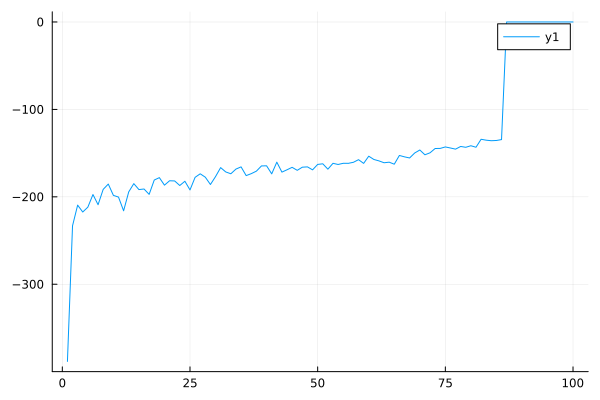

In [210]:
plot(L)

In [211]:
muest

2-element Vector{Vector{Float64}}:
 [2.9734795374698484, 3.707349921599242]
 [6.571695730673599, 9.050635381674033]

In [200]:
nuest

0.0

In [202]:
muest

2-element Vector{Vector{Float64}}:
 [-6.227331864076605, -6.713534302525732]
 [-10.769631638543334, -7.084839590454161]